In [289]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [290]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in [0, 4]:
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

20

In [291]:
images = []
for sample_idx in samples_idx.flatten():
    images.append(mndata.train_images[sample_idx])

images = np.array(images, dtype='float')
images = images / 255
images.shape

(20, 784)

In [292]:
def simple_plot(T: list):
    T_arr = np.array(T, dtype=float)

    fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
    axs.plot(np.arange(T_arr.size), T_arr)


    plt.show()

In [293]:
def show_image(image: ndarray):
    # figure(figsize=(15, 10))

    imshow(np.array(image),
        interpolation='none',
        aspect='equal',
        cmap='bone',
        )

    axis("off")

    show()

In [294]:
def show_images_table(images_2d: ndarray, img_side: int = 28, row_size=10):
    column_size = int(images.shape[0] / row_size)

    shaped_images = images_2d.reshape(column_size, row_size, img_side, img_side)
    shaped_images = shaped_images.swapaxes(1, 2).reshape(column_size*img_side, row_size*img_side)

    figure(figsize=(15, 10))

    imshow(shaped_images,
           interpolation='none',
           aspect='equal',
           cmap='bone',
           )
    
    axis("off")

# show_images_table(images_2d=images)
images.shape

(20, 784)

In [295]:
layer_size = n_mnist_pixels

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size)
print('W', W.shape, W.max(), W.min(), np.median(W))

iter_cnt = 100

eps0 = 0.01
eps = eps0

for img in images[:1]:
    I = np.copy(img)
    # print(img)

    T = []
    OST = []

    for iter_idx in range(iter_cnt):
        # eps = (iter_cnt - iter_idx) * eps0

        # infer
        DO = np.exp((I - W)**2 * -20.0)
        O += np.sum(DO, axis=1)

        O[np.where(O < np.mean(O) * 1.0)] = 0

        # train
        O /= np.max(O)
        dW = (I - W) * eps * O
        dW[np.where(O <= 0)] = 0

        # update
        W += dW

        # recur
        I = np.copy(O)

        # stats
        t = np.sum(O > 0)
        T.append(t)

        OST.append(np.copy(O))

print('W', W.shape, W.max(), W.min(), np.median(W))


W (784, 784) 0.9999988802984928 1.2956621636694976e-06 0.5002557695278955
W (784, 784) 0.9873091718437945 0.0014311633363173135 0.5300261671400323


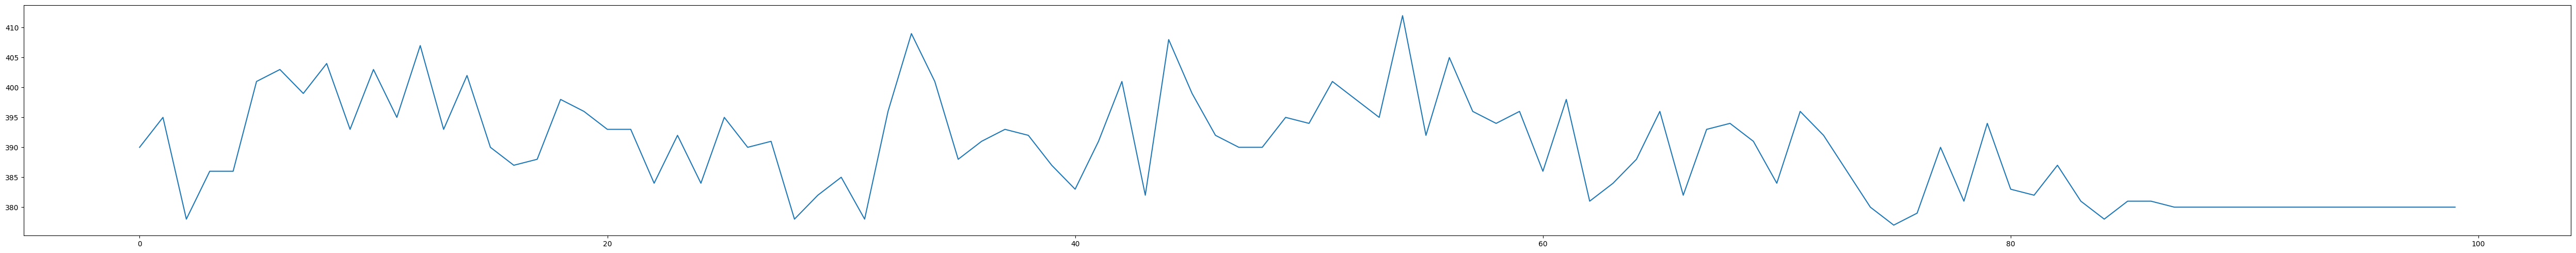

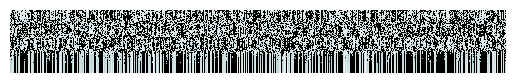

In [296]:
simple_plot(T=T)
show_image(image=OST)